## Advanced McStas features: EXTEND and WHEN
In this tutorial we will look at two advanced features in McStas, the EXTEND block and WHEN condition. Here we will use them to flag certain neutrons with EXTEND, and only record them in monitors when the flag is set using a WHEN condition.

In [1]:
from mcstasscript.interface import instr, functions, plotter

In [2]:
instrument = instr.McStas_instr("python_tutorial", input_path="run_folder")

### Set up an example McStas instrument
First we set up an example instrument conisiting of a source, a guide and a position/divergence monitor. The guide is set up such that it only has mirrors on the left and right side, and absorbs neutrons if they hit the top or bottom. This is done to look at the horizontal behavior independently from the vertical, as this is easier to analyze.

In [3]:
src = instrument.add_component("source", "Source_simple")

src.xwidth = 0.02
src.yheight = 0.02
src.focus_xw = guide_opening_w = 0.05
src.focus_yh = guide_opening_h = 0.06
src.dist = 1.5
src.flux = 1E13

instrument.add_parameter("wavelength", value=5.0, comment="Wavelength in [Ang]")
src.lambda0="wavelength"
src.dlambda="0.001*wavelength"

In [4]:
guide = instrument.add_component("guide", "Guide_gravity", AT=[0,0,1.5], RELATIVE=src)
guide.w1 = guide_opening_w
guide.h1 = guide_opening_h
guide.w2 = guide_opening_w
guide.h2 = guide_opening_h
guide.l = guide_length = 15
guide.mleft = 4.0
guide.mright = 4.0
guide.mtop = 0.0
guide.mbottom = 0.0
guide.G = -9.82

In [5]:
acceptance = instrument.add_component("acceptance", "DivPos_monitor")
acceptance.set_AT([0,0, guide_length + 0.1], RELATIVE=guide)
acceptance.nh = 200
acceptance.ndiv = 200
acceptance.filename = '"acceptance.dat"'
acceptance.xwidth = 0.08
acceptance.yheight = 0.05
acceptance.maxdiv_h = 1.5
acceptance.restore_neutron = 1

INFO: Using directory: "/Users/madsbertelsen/Teaching/Python/IKON-Python-course/python-course-ikon/notebooks/5_McStas/data_folder/mcstas_EXTEND_WHEN"
INFO: Regenerating c-file: python_tutorial.c
CFLAGS=
INFO: Recompiling: ./python_tutorial.out
INFO: ===
INFO: Placing instr file copy python_tutorial.instr in dataset /Users/madsbertelsen/Teaching/Python/IKON-Python-course/python-course-ikon/notebooks/5_McStas/data_folder/mcstas_EXTEND_WHEN

Detector: acceptance_I=1.59547e+07 acceptance_ERR=28305.7 acceptance_N=376986 "acceptance.dat"

Plotting data with name acceptance


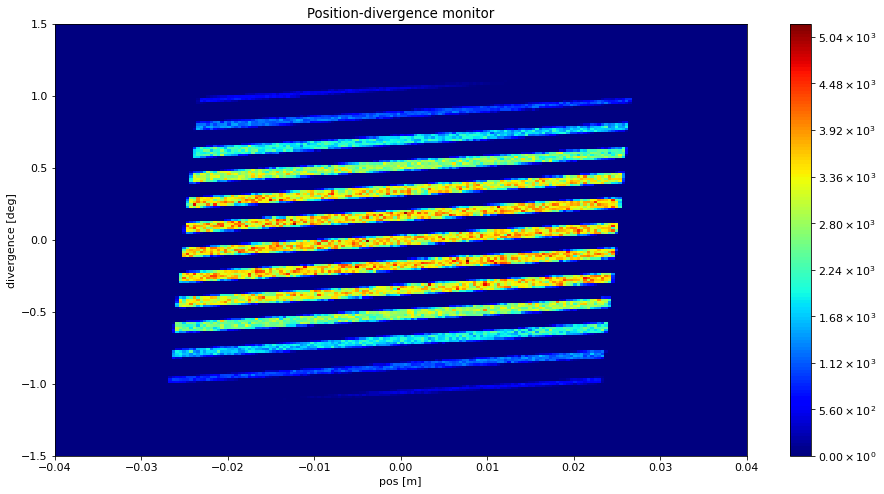

In [6]:
data = instrument.run_full_instrument(ncount=5E6, foldername="data_folder/mcstas_EXTEND_WHEN",
                                      increment_folder_name=True,
                                      parameters={"wavelength" : 2.8})

plotter.make_sub_plot(data)

### Interpreting the data
Here we see an acceptance monitor, with position along the x-axis and divergence along the y-axis. The guide is under illuminated by the small source, so there are gaps in the acceptance diagram. We see the position and divergence of the beam consist of a large number of stripes, the ones with lowest divergence has the largest intensity.

## Add an flag
A flag is just a name for a variable that records some information on the neutron during the simulation, and can be used later to make a decision. Here we could check how many times the ray was reflected in the guide.

We use an EXTEND block after a component to access variables internal to the component in the instrument scope. We declare a variable in the instrument scope called *n_reflections*. In the component scope, one can use the SCATTERED variable which contains the number of times the ray has encountered the SCATTER keyword within the component. Usually this is done when entering and leaving, and under each scattering / reflection, so the number of reflections is SCATTERED - 2.

In [7]:
instrument.add_declare_var("int", "n_reflections")
guide.append_EXTEND("n_reflections = SCATTERED - 2;")
print(guide)

COMPONENT guide = Guide_gravity
  w1 = 0.05 [m]
  h1 = 0.06 [m]
  w2 = 0.05 [m]
  h2 = 0.06 [m]
  l = 15 [m]
  mleft = 4.0 [1]
  mright = 4.0 [1]
  mtop = 0.0 [1]
  mbottom = 0.0 [1]
  G = -9.82 [m/s2]
AT [0, 0, 1.5] RELATIVE source
EXTEND %{
n_reflections = SCATTERED - 2;
%}



## Use the flag to limit what is recorded in a monitor
A WHEN statement can be used to activate / deactivate a component when some condition is true / false. For example we could require 0 reflection in our guide. We add a few monitors similar to the original, with the only difference being WHEN statements requiring 0, 1 or 2 reflections in the guide for the component to be active. We use a for loop to add the similar components, only changing the component instance name, filename and WHEN statement between each.

In [8]:
reflection_numbers = [0, 1, 2]

for reflections in reflection_numbers:
    reflections_string = str(reflections)
    
    acceptance = instrument.add_component("acceptance_" + reflections_string, "DivPos_monitor")
    acceptance.filename = '"acceptance_' + reflections_string + '.dat"'
    acceptance.set_WHEN("n_reflections == " + reflections_string)
    
    acceptance.set_AT([0,0, guide_length + 0.1], RELATIVE=guide)
    acceptance.nh = 200
    acceptance.ndiv = 200
    acceptance.xwidth = 0.08
    acceptance.yheight = 0.05
    acceptance.maxdiv_h = 1.5
    acceptance.restore_neutron = 1
    
    print(acceptance)

COMPONENT acceptance_0 = DivPos_monitor
  nh = 200 [1]
  ndiv = 200 [1]
  filename = "acceptance_0.dat" [string]
  xwidth = 0.08 [m]
  yheight = 0.05 [m]
  maxdiv_h = 1.5 [degrees]
  restore_neutron = 1 [1]
WHEN (n_reflections == 0)
AT [0, 0, 15.1] RELATIVE guide

COMPONENT acceptance_1 = DivPos_monitor
  nh = 200 [1]
  ndiv = 200 [1]
  filename = "acceptance_1.dat" [string]
  xwidth = 0.08 [m]
  yheight = 0.05 [m]
  maxdiv_h = 1.5 [degrees]
  restore_neutron = 1 [1]
WHEN (n_reflections == 1)
AT [0, 0, 15.1] RELATIVE guide

COMPONENT acceptance_2 = DivPos_monitor
  nh = 200 [1]
  ndiv = 200 [1]
  filename = "acceptance_2.dat" [string]
  xwidth = 0.08 [m]
  yheight = 0.05 [m]
  maxdiv_h = 1.5 [degrees]
  restore_neutron = 1 [1]
WHEN (n_reflections == 2)
AT [0, 0, 15.1] RELATIVE guide



### Running the simulation
We now run the simulation with the new monitors to see how they differ from the original version.

INFO: Using directory: "/Users/madsbertelsen/Teaching/Python/IKON-Python-course/python-course-ikon/notebooks/5_McStas/data_folder/mcstas_EXTEND_WHEN_0"
INFO: Regenerating c-file: python_tutorial.c
CFLAGS=
INFO: Recompiling: ./python_tutorial.out
./python_tutorial.c:9351:21: warning: equality comparison with extraneous parentheses [-Wparentheses-equality]
if (( n_reflections == 0 ))
      ~~~~~~~~~~~~~~^~~~
./python_tutorial.c:9351:21: note: remove extraneous parentheses around the comparison to silence this warning
if (( n_reflections == 0 ))
    ~               ^    ~
./python_tutorial.c:9351:21: note: use '=' to turn this equality comparison into an assignment
if (( n_reflections == 0 ))
                    ^~
                    =
./python_tutorial.c:9509:21: warning: equality comparison with extraneous parentheses [-Wparentheses-equality]
if (( n_reflections == 1 ))
      ~~~~~~~~~~~~~~^~~~
./python_tutorial.c:9509:21: note: remove extraneous parentheses around the comparison to si

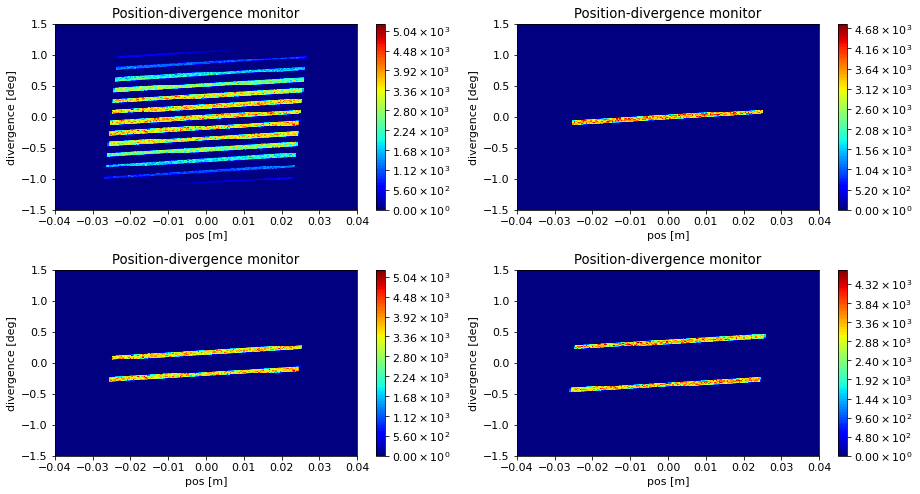

In [9]:
data = instrument.run_full_instrument(ncount=5E6, foldername="data_folder/mcstas_EXTEND_WHEN",
                                      increment_folder_name=True,
                                      parameters={"wavelength" : 2.8})

plotter.make_sub_plot(data)

### Interpretation of the data
The original monitor is unchanged as it was not modified. On the monitors with different numbers of reflections, we see the middle line correspond to zero reflections, the two lines around those are for one reflection and so forth. This explains why the lines further from the center has lower intensity, as they underwent more reflections while also having a larger angle of incidence.

### The McStas instrument file
We here show the generated McStas instrument file in order to clarify how this would be accomplished without the McStasScript API.

In [10]:
with open("run_folder/python_tutorial.instr") as file:
    instrument_string = file.read()
    print(instrument_string)

/********************************************************************************
* 
* McStas, neutron ray-tracing package
*         Copyright (C) 1997-2008, All rights reserved
*         Risoe National Laboratory, Roskilde, Denmark
*         Institut Laue Langevin, Grenoble, France
* 
* This file was written by McStasScript, which is a 
* python based McStas instrument generator written by 
* Mads Bertelsen in 2019 while employed at the 
* European Spallation Source Data Management and 
* Software Center
* 
* Instrument python_tutorial
* 
* %Identification
* Written by: Python McStas Instrument Generator
* Date: 11:11:59 on September 24, 2021
* Origin: ESS DMSC
* %INSTRUMENT_SITE: Generated_instruments
* 
* 
* %Parameters
* 
* %End 
********************************************************************************/

DEFINE INSTRUMENT python_tutorial (
 wavelength = 5 // Wavelength in [Ang]
)

DECLARE 
%{
int n_reflections;
%}

INITIALIZE 
%{
// Start of initialize for generated python_t